In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm

local


In [2]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

CPU times: user 492 ms, sys: 131 ms, total: 623 ms
Wall time: 1.74 s


(1100, 1)

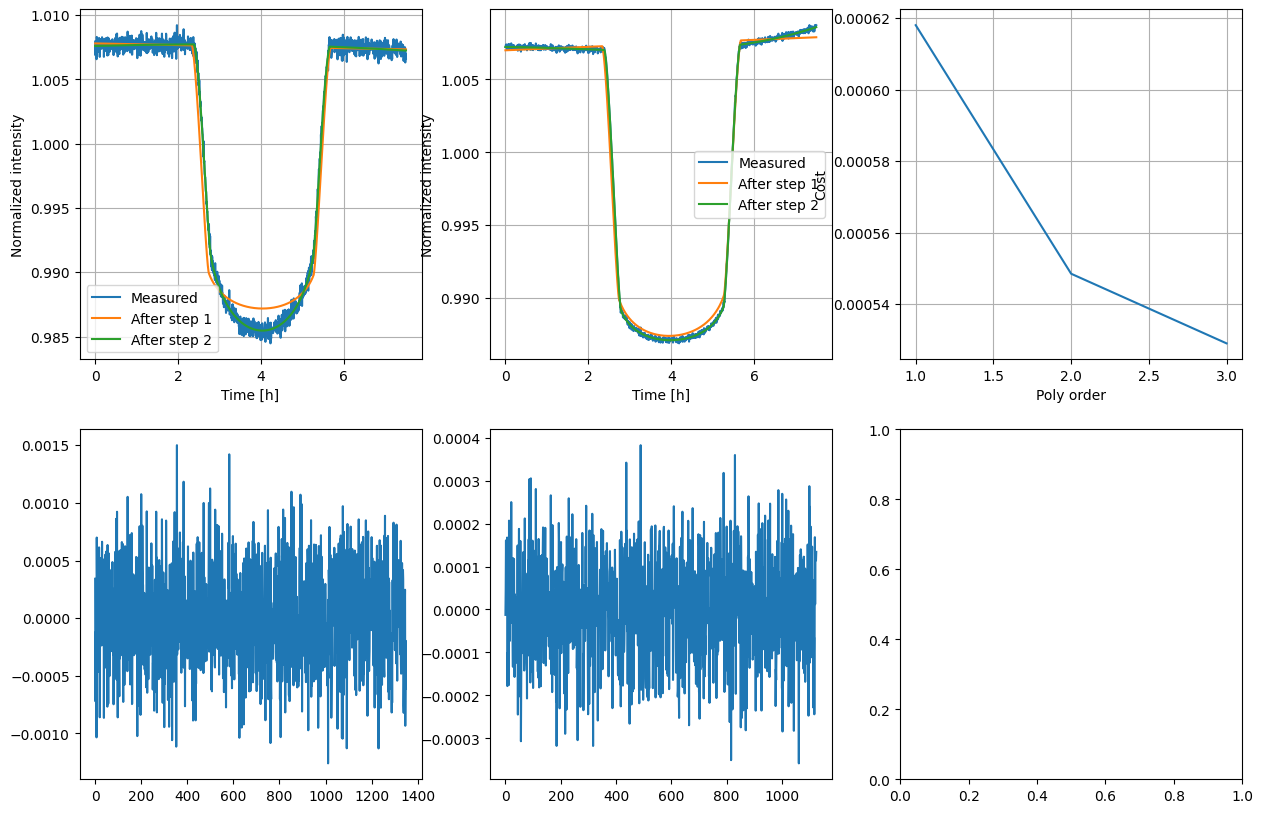

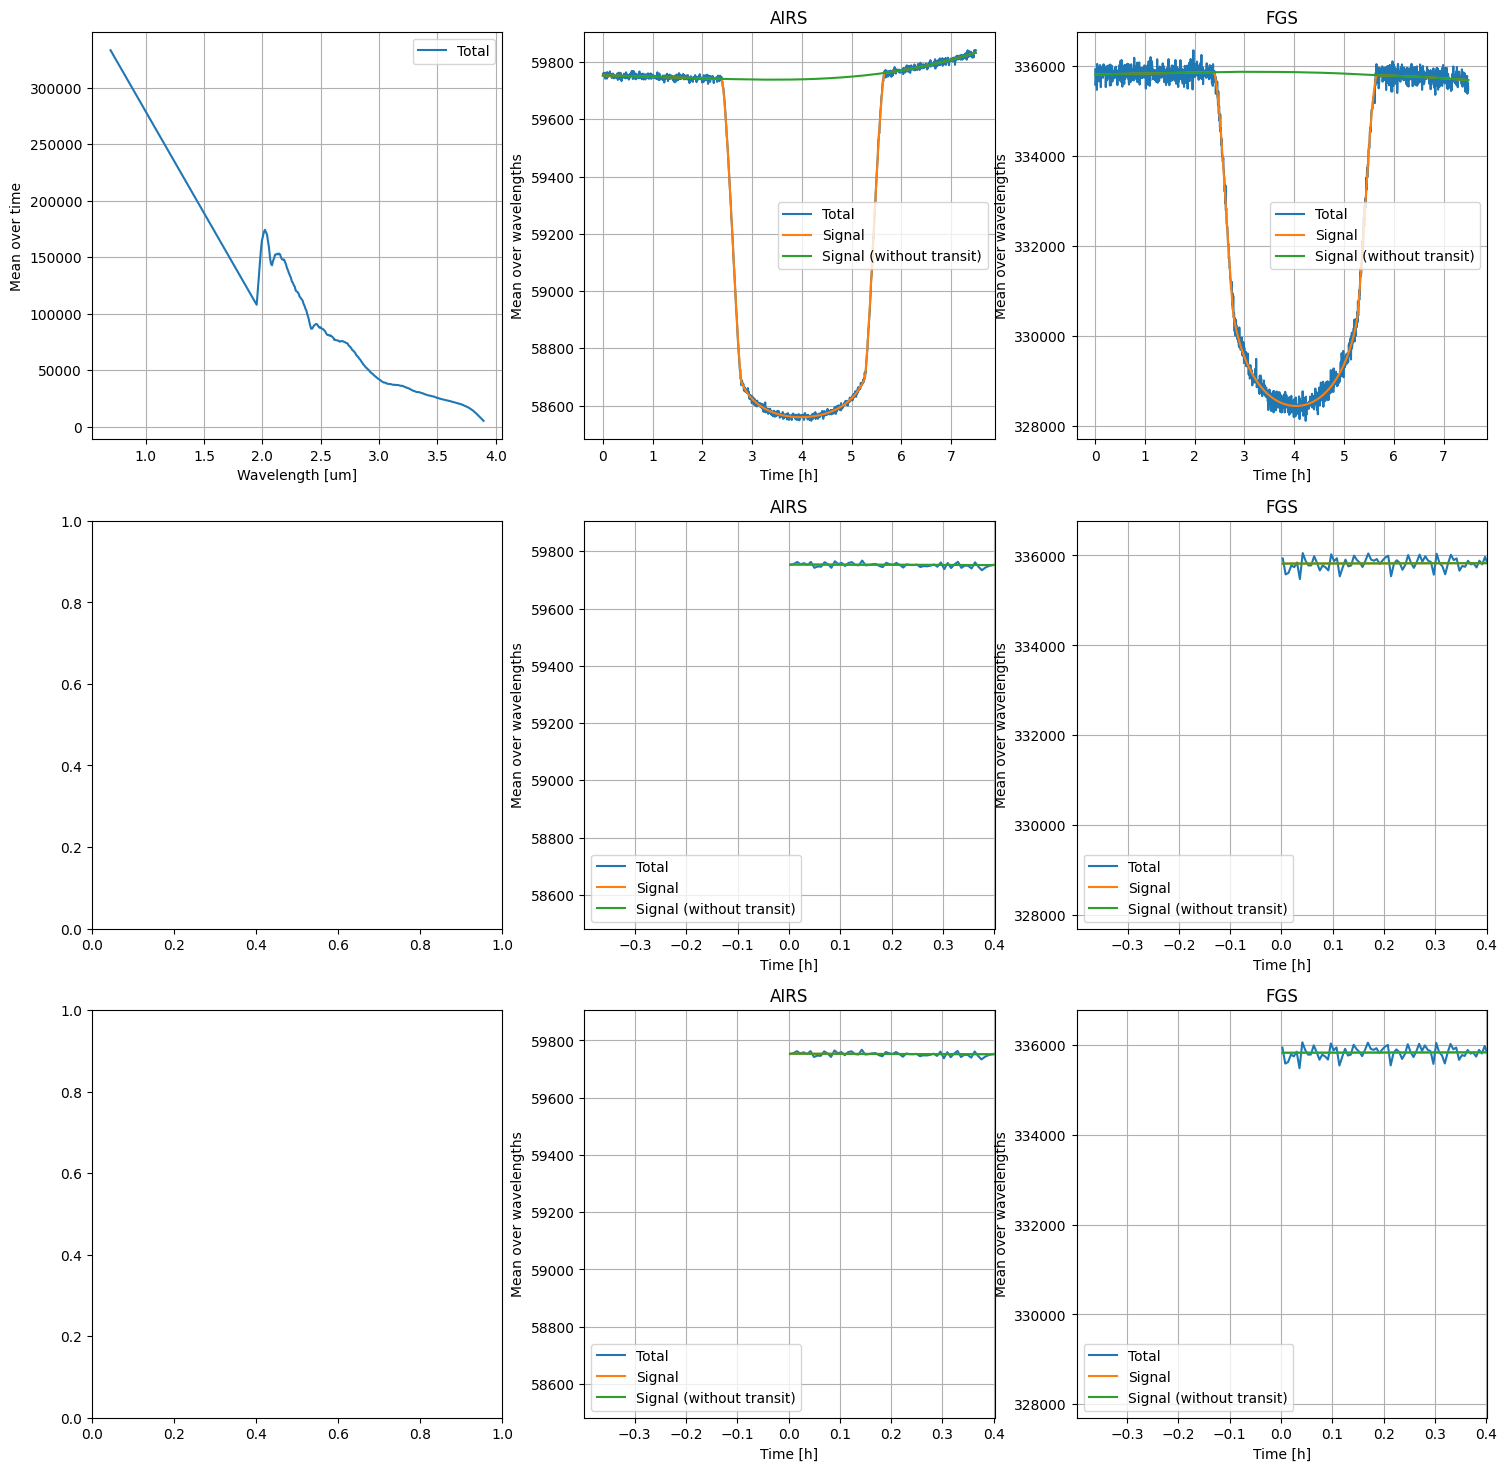

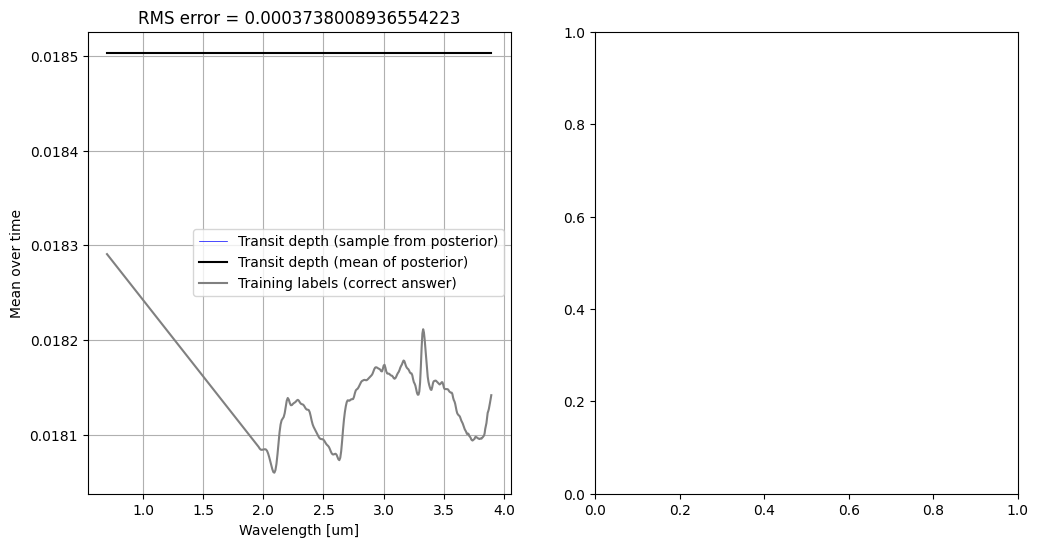

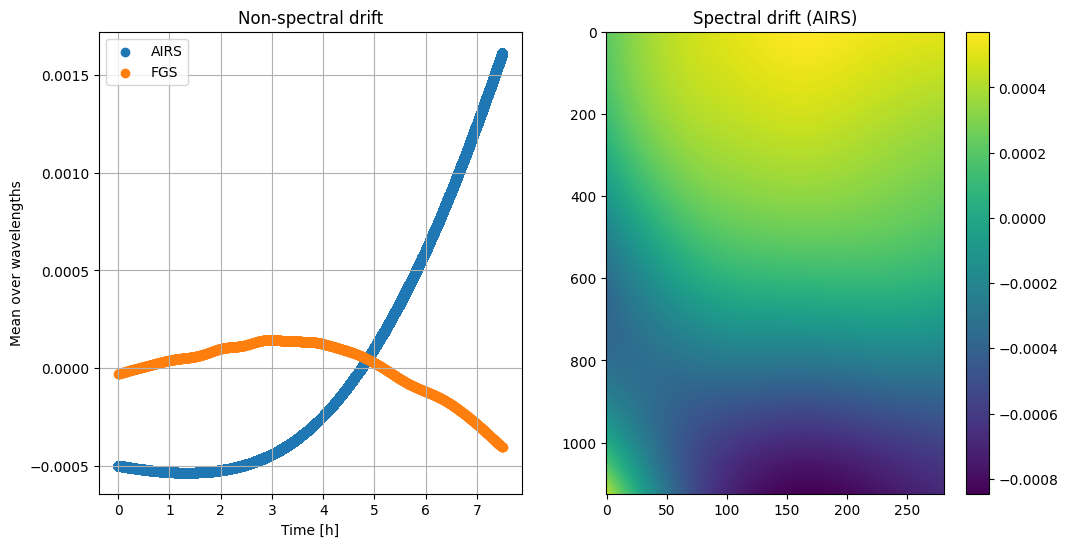

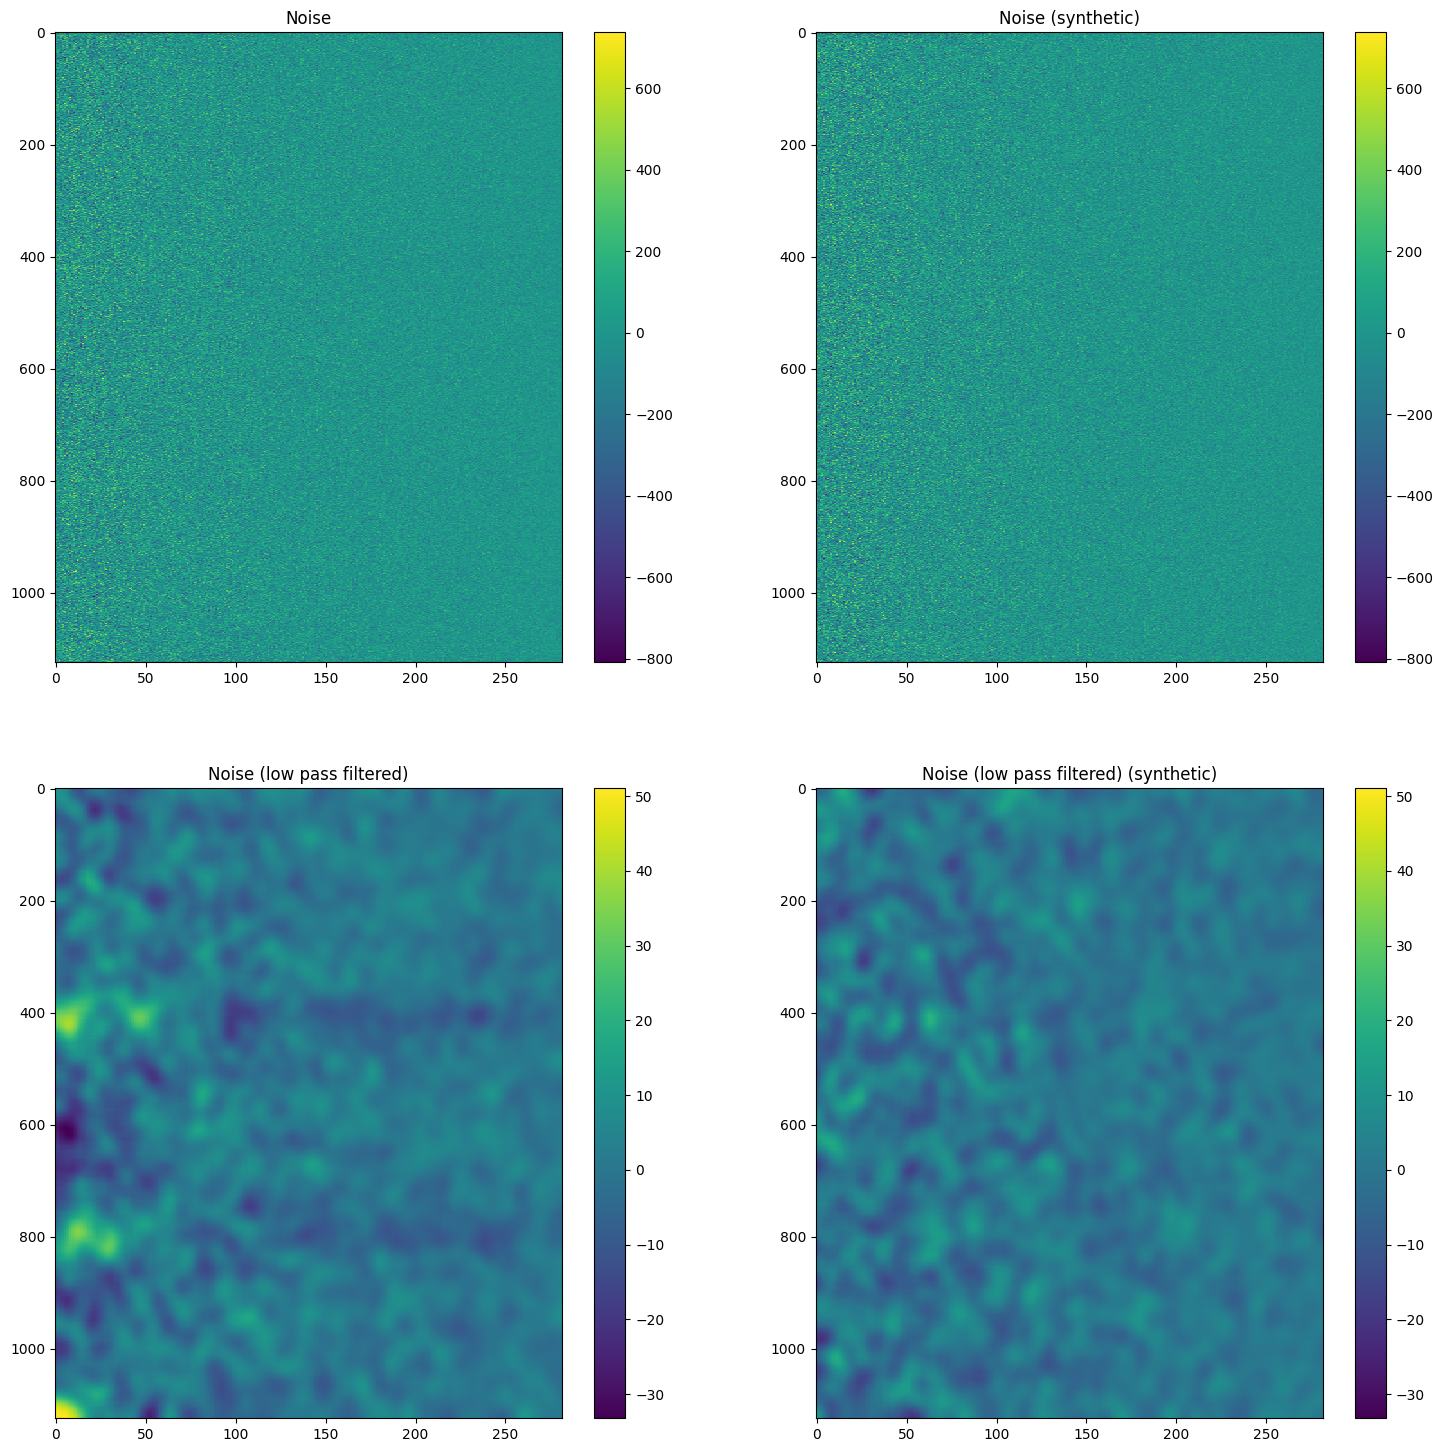

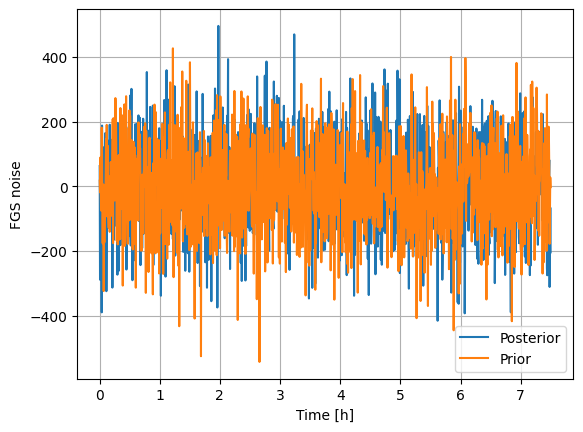

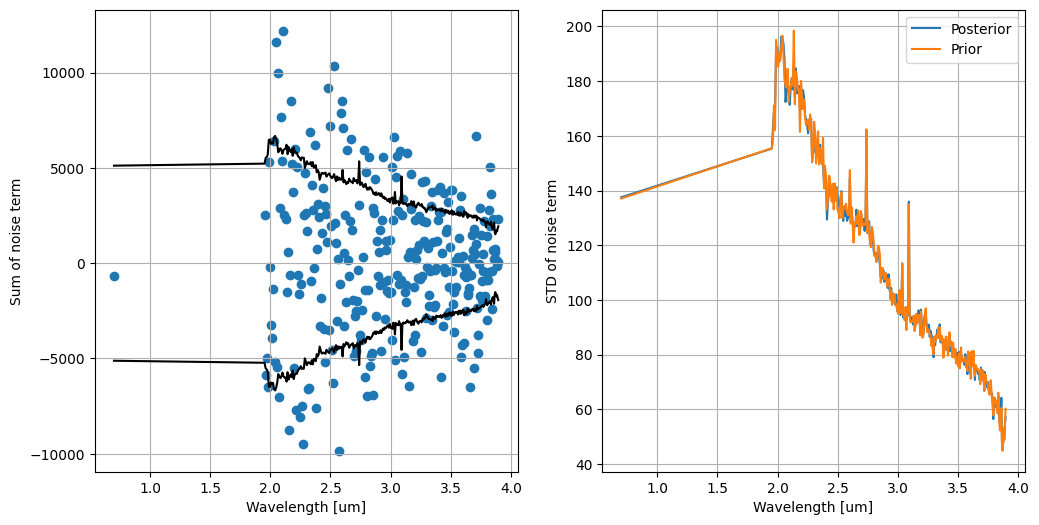

Score:          -36702901364010858315776.0000
RMS error FGS:  212.76 ppm
RMS error AIRS: 374.25 ppm


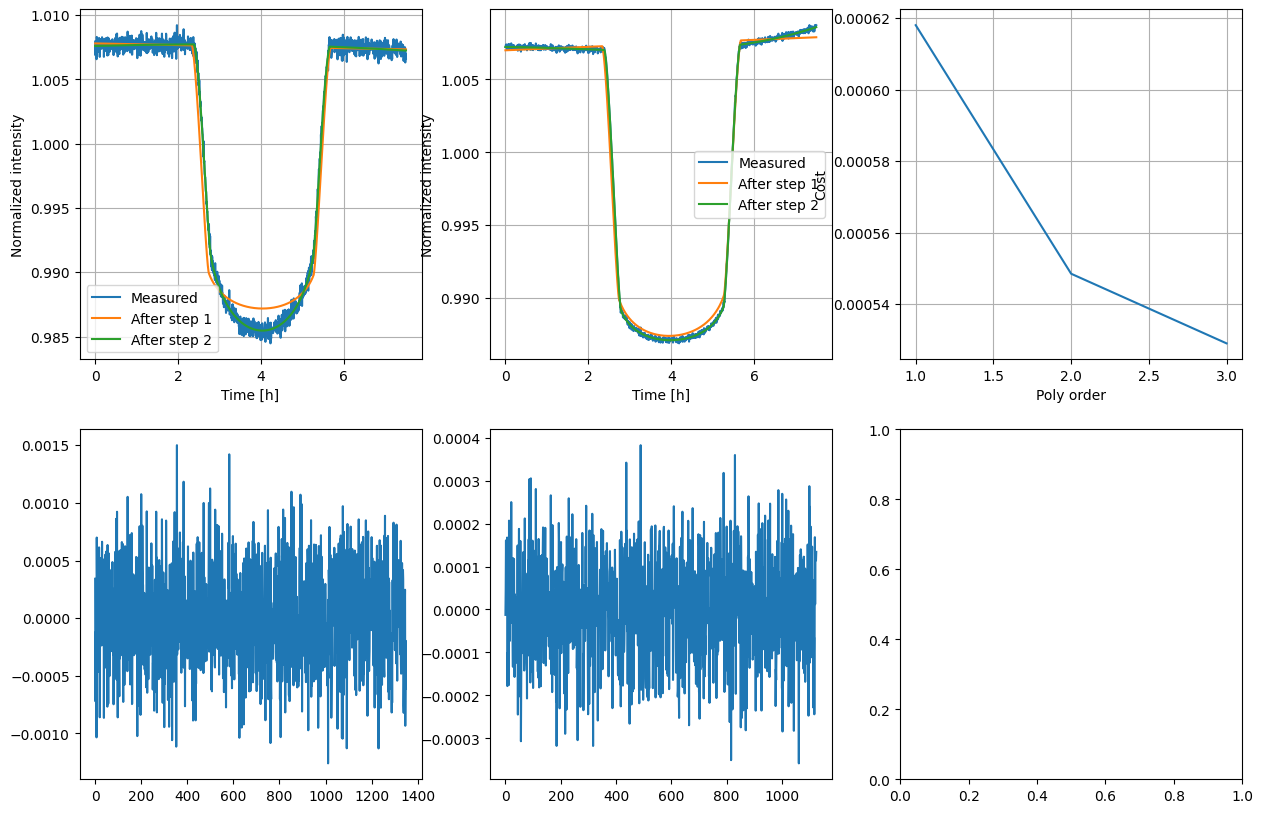

Score:          -1.2686
RMS error FGS:  155.37 ppm
RMS error AIRS: 374.45 ppm
CPU times: user 54.7 s, sys: 10.4 s, total: 1min 5s
Wall time: 31.7 s


(-1.2685788554206925, 0.00015537285070383808, 0.0003744514151032375)

In [50]:
%%time
import gp
import ariel_gp
kgs.profiling=False
kgs.debugging_mode=2
importlib.reload(gp)
importlib.reload(ariel_gp)
model = ariel_gp.PredictionModel()  
model.run_in_parallel=False
model.model_options.n_iter = 2
model.starter_model.do_plots = True
model.plot_final = True
model.train(train_data)
model.starter_model.loaders[0].cache_steps = [5]
model.loaders[0].cache_steps = []
data = train_data[:1]
inferred_data = model.infer(data)
kgs.score_metric(inferred_data, data)
inferred_data_simple = model.starter_model.infer(data)
kgs.score_metric(inferred_data_simple, data)

In [41]:
%debug

> /mnt/d/ariel2/code/core/ariel_gp.py(577)get_prediction_internal()
    575             for i_wavelength in range(len(self.wavelengths)):
    576                 this_transit_params = self.transit_params[i_instance][self.is_AIRS[i_wavelength ]]
--> 577                 this_transit_params.Rp = np.sqrt(-transit_depths[i_wavelength, i_instance])
    578                 light_curve = this_transit_params.light_curve(self.times_per_wavelength[i_wavelength])
    579                 output[self.inds_per_wavelength[i_wavelength], i_instance] = light_curve



ipdb>  q
